## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [3]:
df.shape

(404290, 6)

In [4]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [5]:
df.count()

id              404290
qid1            404290
qid2            404290
question1       404289
question2       404288
is_duplicate    404290
dtype: int64

In [6]:
df.nunique()

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

### Exploration

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
print('Duplicate pairs of questions: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Duplicate pairs of questions: 36.92%


In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total number of unique questions in the training data: {}'.format(len(np.unique(qids))))

Total number of unique questions in the training data: 537933


In [11]:
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Number of questions that appear multiple times: 111780


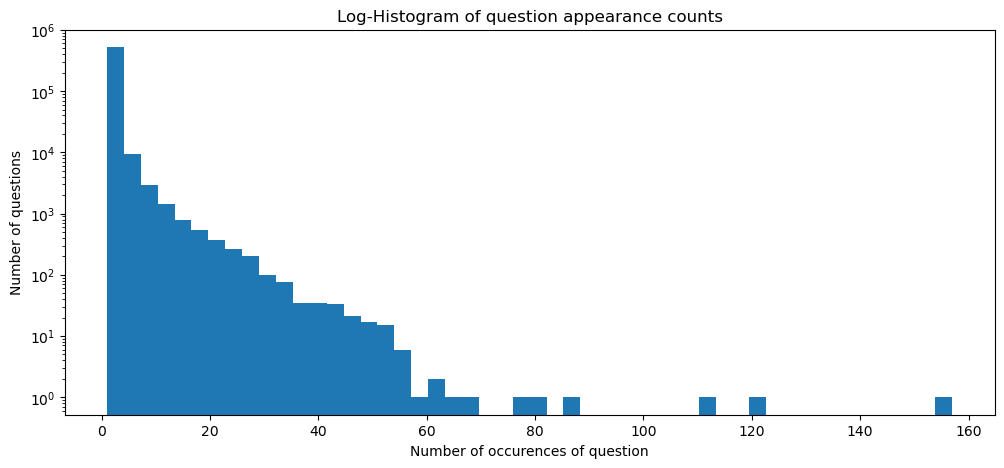

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

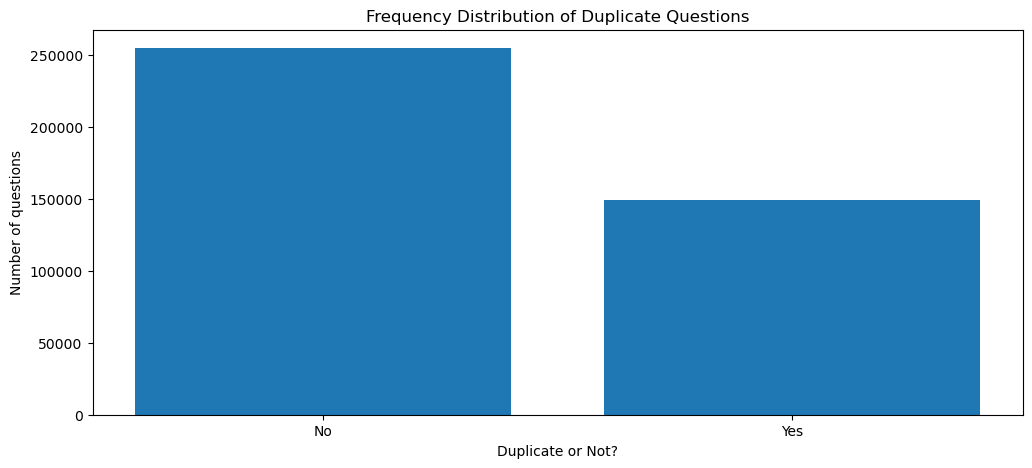

In [34]:
df['is_duplicate?'] = df['is_duplicate'].apply(lambda x: 'No' if x == 0.0 else 'Yes')

plt.figure(figsize=(12, 5))
plt.bar(list(df['is_duplicate?'].unique()), list(df['is_duplicate'].value_counts()))
plt.title('Frequency Distribution of Duplicate Questions')
plt.xlabel('Duplicate or Not?')
plt.ylabel('Number of questions')
plt.show()

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [13]:
df[df['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [14]:
df[df['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [15]:
# drop the null rows.

df.drop(363362, inplace=True)

df.drop([105780, 201841], inplace=True)

In [16]:
df.count()

id              404287
qid1            404287
qid2            404287
question1       404287
question2       404287
is_duplicate    404287
dtype: int64

In [17]:
#consider the first 50 thousand rows considering the lack of processing power and memory on the system.

df_50 = df.head(50000)

In [ ]:
df_50.shape

(50000, 6)

In [19]:
#check the data balance ratio. Is it same as the original dataset?

print('Duplicate pairs of questions: {}%'.format(round(df_50['is_duplicate'].mean()*100, 2)))

Duplicate pairs of questions: 37.3%


In [30]:
# split all questions into words and add these together to create a central corpus of questions.

import nltk
from nltk.tokenize import word_tokenize

corpus = []

framelength = df_50.shape[0]

i = 0

while i < framelength:
    corpus.append(word_tokenize(df_50.iloc[i]['question1']))
    corpus.append(word_tokenize(df_50.iloc[i]['question2']))  
    i += 1

In [31]:
# Check the total length of corpus which should be total of 100000 questions.

print("total length of the corpus:", len(corpus))

print("Sample question 1 after tokenization:", corpus[0])
print("Sample question 1 after tokenization:", corpus[1])

total length of the corpus: 100000
Sample question 1 after tokenization: ['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']
Sample question 1 after tokenization: ['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', '?']


In [33]:
# remove punctuation from each question set

import string
from nltk.corpus import stopwords

table = str.maketrans('', '', string.punctuation)

stop_words = set(stopwords.words('english'))

corpus_cleaned = []

corpuslength = len(corpus)

i = 0

while i < corpuslength: 
    doc_nopunc = [w.translate(table) for w in corpus[i]]
    doc_alpha = [word for word in doc_nopunc if word.isalpha()]
    doc_lower = [w.lower() for w in doc_alpha]
    doc_final = [w for w in doc_lower if not w in stop_words]

    corpus_cleaned.append(doc_final)

    i += 1

In [36]:
# convert the list of words to string set to be able to vectorize them.

corpus_transformed = []

for doc in corpus_cleaned:
    corpus_transformed.append(' '.join(map(str,doc)))

print(corpus_transformed[0])
print(corpus_transformed[1])
print(corpus_transformed[2])
print(corpus_transformed[3])

step step guide invest share market india
step step guide invest share market
story kohinoor kohinoor diamond
would happen indian government stole kohinoor kohinoor diamond back


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [37]:
# vectorize the corpus of questions. Limit the vocabulary set to 500 to conserve on the processing power.

from sklearn.feature_extraction.text import TfidfVectorizer

# create the transform
vectorizer = TfidfVectorizer(use_idf=True, strip_accents='ascii', max_features=500)

# tokenize and build vocab
vectorizer.fit(corpus_transformed)

# summarize
print('vocabulary: ', vectorizer.vocabulary_)
print('idfs: ', vectorizer.idf_)

vocabulary:  {'invest': 232, 'market': 275, 'india': 221, 'story': 420, 'would': 493, 'happen': 196, 'indian': 222, 'government': 188, 'back': 28, 'increase': 220, 'speed': 411, 'internet': 230, 'using': 460, 'find': 160, 'math': 277, 'one': 311, 'water': 471, 'say': 380, 'buy': 51, 'phone': 328, 'video': 462, 'games': 173, 'good': 185, 'great': 189, 'use': 458, 'instead': 226, 'company': 80, 'hack': 194, 'free': 167, 'things': 437, 'tell': 432, 'read': 361, 'youtube': 499, 'see': 385, 'make': 269, 'learn': 247, 'first': 161, 'experience': 149, 'like': 254, 'change': 65, 'student': 421, 'visa': 465, 'green': 190, 'card': 58, 'us': 456, 'compare': 81, 'canada': 56, 'trump': 447, 'mean': 279, 'international': 229, 'students': 422, 'affect': 4, 'study': 423, 'girls': 178, 'want': 468, 'friends': 169, 'guy': 192, 'guys': 193, 'feel': 159, 'girl': 176, 'many': 274, 'quora': 359, 'questions': 358, 'google': 186, 'people': 324, 'ask': 23, 'easily': 128, 'best': 40, 'digital': 117, 'marketing'

In [38]:
# check the size of vocabulary set.

len(vectorizer.vocabulary_)

500

In [40]:
# create vector of each questions based on the vocabulary set.

vector = vectorizer.transform(corpus_transformed)

In [42]:
# check total vector matrix shape which should contain 100000 questions and 500 word dimention set.

vector.shape

(100000, 500)

In [47]:
# check sample vector for question and print the words which are considered in the vector for question 1. Owing to limited vector size, only limited words are being displayed.

i = 0
while i < len:
    if vector[0].toarray()[0][i] != 0.0:
        print(i, ":", vector[0].toarray()[0][i])

    i += 1

221 : 0.3996581679129399
232 : 0.6646010232649997
275 : 0.6313309977306577


In [ ]:
# convert the full vector of 100000 questions into 50000 original set of questions with each question vector being the addition of its original two question in each row.
# The assumption is that on combining the two questions of each dataset row, the repeat words will get added in weightage and may influence the decision of duplication
# in a positive way.

vector_q = np.zeros((1, vector.shape[1]))

i = 0

while i < vector.shape[0]:
    vector_q = np.append(vector_q,(vector[i] + vector[i+1]).toarray(), axis=0)
    i += 2
    print(i)

vector_q = np.delete(vector_q, 0, 0)

vector_q.shape

In [57]:
# check whether addition of two questions into a single question vector has materialized with sample check on the first row.
i = 0
while i < vector_q.shape[1]:
    if vector_q[0][i] != 0.0:
        print(i, ":", vector_q[0][i])
    i += 1

221 : 0.3996581679129399
232 : 1.3896222321048273
275 : 1.3200575376087396


In [59]:
vector_q.shape

(50000, 500)

In [61]:
# get the result array into a separate row for input to the model.

y = np.array(df_50['is_duplicate'].head(50000))

In [99]:
y = y.reshape(-1,1)

In [102]:
y.shape

(50000, 1)

In [114]:
x = vector_q

In [115]:
# normalize the vector to keep all the values between 0 and 1.

import numpy as np

X = (x-np.min(x))/(np.max(x)-np.min(x))

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
X_train.shape

(40000, 500)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [119]:
#choose xgboost as model to performn the fit. The model runs only for 10 seconds owing to small vector size.

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

accuracy Score: 0.7059


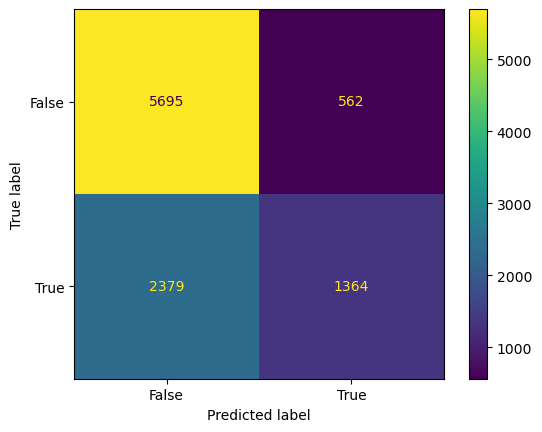

In [120]:
# predict the values and print the accuracy score and covariance matrix.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = xgb_cl.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred))

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()

In [121]:
# run the ada boost classifier to chek its performance.

from sklearn.ensemble import AdaBoostClassifier

adb_cl = AdaBoostClassifier()

adb_cl.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier()

accuracy Score: 0.6684


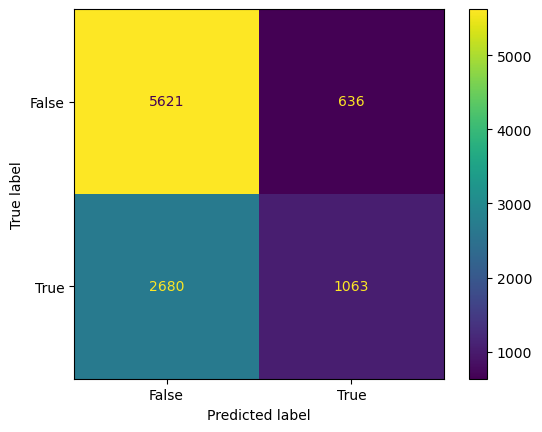

In [122]:
# print the accuracy score and covariance matrix.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred3 = adb_cl.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred3))

confusion_matrix = confusion_matrix(y_test, y_pred3)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()